<a href="https://colab.research.google.com/github/ynsboztepe/Pneumonia-Detection-ResNet18/blob/main/DeepLearningCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%writefile model.py
import torch
import torch.nn as nn
from torchvision import models

class PneumoniaNet(nn.Module):
    def __init__(self, num_classes=2):
        """
        Initializes the PneumoniaNet model based on ResNet18.
        Args:
            num_classes (int): Number of output classes (Normal vs Pneumonia).
        """
        super(PneumoniaNet, self).__init__()
        # Load pre-trained ResNet18 model
        self.backbone = models.resnet18(pretrained=True)

        # Freeze early layers to preserve learned features (Optional but recommended for small datasets)
        # for param in self.backbone.parameters():
        #     param.requires_grad = False

        # Replace the final fully connected layer
        # ResNet18's fc input features are 512
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5), # Prevent overfitting
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        """
        Forward pass of the neural network.
        """
        return self.backbone(x)

Writing model.py


In [2]:
%%writefile utils.py
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    """
    Saves the model checkpoint.
    """
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    """
    Loads a saved checkpoint.
    """
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

def show_image_samples(loader, classes):
    """
    Displays a batch of images for verification.
    """
    dataiter = iter(loader)
    images, labels = next(dataiter)
    images = images.numpy() # Convert to numpy for matplotlib

    fig = plt.figure(figsize=(15, 5))
    for idx in range(min(5, len(images))):
        ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
        # Un-normalize logic if needed (assuming standard normalization)
        img = images[idx].transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(classes[labels[idx]])
    plt.show()

Writing utils.py


In [3]:
%%writefile train.py
import torch
from tqdm import tqdm # For progress bars

def train_one_epoch(loader, model, optimizer, loss_fn, scaler, device):
    """
    Trains the model for one epoch.
    """
    model.train()
    loop = tqdm(loader, leave=True)
    running_loss = 0.0
    correct_predictions = 0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        with torch.cuda.amp.autocast(): # Mixed precision for faster training
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # Backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Statistics
        running_loss += loss.item() * data.size(0)
        _, preds = torch.max(predictions, 1)
        correct_predictions += torch.sum(preds == targets.data)

        loop.set_description(f"Training")
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct_predictions.double() / len(loader.dataset)
    return epoch_loss, epoch_acc

def validate_model(loader, model, loss_fn, device):
    """
    Evaluates the model on validation/test set.
    """
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            targets = targets.to(device)

            predictions = model(data)
            loss = loss_fn(predictions, targets)

            running_loss += loss.item() * data.size(0)
            _, preds = torch.max(predictions, 1)
            correct_predictions += torch.sum(preds == targets.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct_predictions.double() / len(loader.dataset)

    return epoch_loss, epoch_acc, all_preds, all_labels

Writing train.py


In [4]:
!ls

model.py  sample_data  train.py  utils.py


In [5]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:20<00:00, 205MB/s]
100% 2.29G/2.29G [00:20<00:00, 120MB/s]


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from model import PneumoniaNet
from utils import save_checkpoint, load_checkpoint, show_image_samples
from train import train_one_epoch, validate_model

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Working on device: {DEVICE}")

LEARNING_RATE = 1e-4
BATCH_SIZE = 32
NUM_EPOCHS = 10

Working on device: cuda


Classes: ['NORMAL', 'PNEUMONIA']


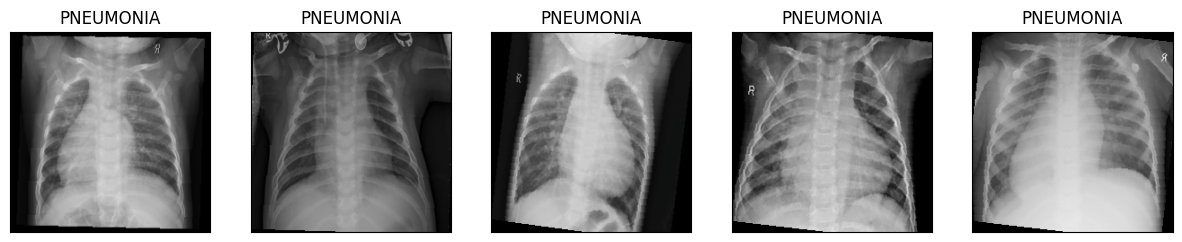

In [7]:
TRAIN_DIR = "chest_xray/train"
VAL_DIR = "chest_xray/val"
TEST_DIR = "chest_xray/test"

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(VAL_DIR, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(TEST_DIR, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = train_dataset.classes
print(f"Classes: {class_names}")

show_image_samples(train_loader, class_names)

In [8]:
model = PneumoniaNet(num_classes=2).to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

train_losses, train_accs = [], []
val_losses, val_accs = [], []

print("Training Started...")
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    # Train
    t_loss, t_acc = train_one_epoch(train_loader, model, optimizer, loss_fn, scaler, DEVICE)
    train_losses.append(t_loss)
    train_accs.append(t_acc.cpu().item())

    # Validation
    v_loss, v_acc, _, _ = validate_model(test_loader, model, loss_fn, DEVICE)
    val_losses.append(v_loss)
    val_accs.append(v_acc.cpu().item())

    print(f"Train Loss: {t_loss:.4f}, Acc: {t_acc:.4f} | Val Loss: {v_loss:.4f}, Acc: {v_acc:.4f}")

    if epoch == NUM_EPOCHS - 1:
        save_checkpoint({'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()})

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]
/tmp/ipython-input-676323869.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training Started...
Epoch 1/10


  0%|          | 0/163 [00:00<?, ?it/s]/content/train.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # Mixed precision for faster training
Training: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s, loss=0.114]


Train Loss: 0.1166, Acc: 0.9542 | Val Loss: 0.3702, Acc: 0.8878
Epoch 2/10


Training: 100%|██████████| 163/163 [01:16<00:00,  2.14it/s, loss=0.012]


Train Loss: 0.0576, Acc: 0.9795 | Val Loss: 0.8520, Acc: 0.7772
Epoch 3/10


Training: 100%|██████████| 163/163 [01:16<00:00,  2.12it/s, loss=0.0913]


Train Loss: 0.0477, Acc: 0.9827 | Val Loss: 0.6727, Acc: 0.8221
Epoch 4/10


Training: 100%|██████████| 163/163 [01:16<00:00,  2.14it/s, loss=0.0115]


Train Loss: 0.0326, Acc: 0.9889 | Val Loss: 0.6204, Acc: 0.8542
Epoch 5/10


Training: 100%|██████████| 163/163 [01:16<00:00,  2.14it/s, loss=0.0222]


Train Loss: 0.0290, Acc: 0.9885 | Val Loss: 0.7767, Acc: 0.8333
Epoch 6/10


Training: 100%|██████████| 163/163 [01:16<00:00,  2.14it/s, loss=0.00691]


Train Loss: 0.0314, Acc: 0.9902 | Val Loss: 0.7837, Acc: 0.7885
Epoch 7/10


Training: 100%|██████████| 163/163 [01:16<00:00,  2.12it/s, loss=0.0129]


Train Loss: 0.0306, Acc: 0.9895 | Val Loss: 0.8104, Acc: 0.8045
Epoch 8/10


Training: 100%|██████████| 163/163 [01:16<00:00,  2.13it/s, loss=0.00149]


Train Loss: 0.0265, Acc: 0.9904 | Val Loss: 0.7177, Acc: 0.8413
Epoch 9/10


Training: 100%|██████████| 163/163 [01:16<00:00,  2.14it/s, loss=0.00443]


Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.9099, Acc: 0.8397
Epoch 10/10


Training: 100%|██████████| 163/163 [01:16<00:00,  2.13it/s, loss=0.00112]


Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 1.9446, Acc: 0.7708
=> Saving checkpoint


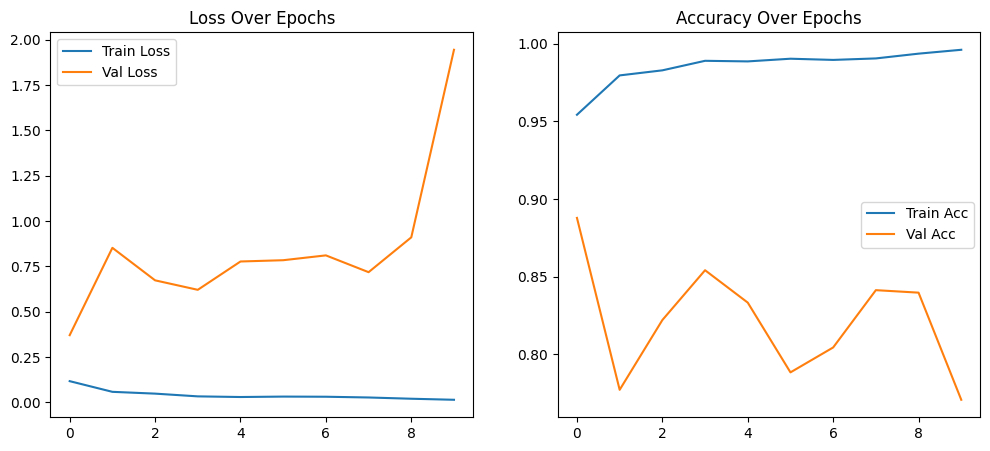

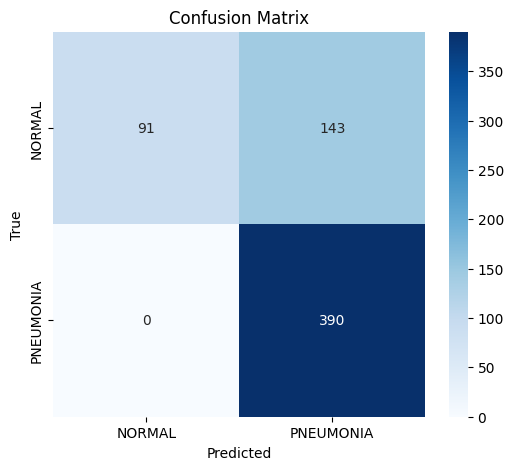

              precision    recall  f1-score   support

      NORMAL       1.00      0.39      0.56       234
   PNEUMONIA       0.73      1.00      0.85       390

    accuracy                           0.77       624
   macro avg       0.87      0.69      0.70       624
weighted avg       0.83      0.77      0.74       624



In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

_, _, all_preds, all_labels = validate_model(test_loader, model, loss_fn, DEVICE)

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))